<a href="https://colab.research.google.com/github/HuyKhoi-code/AI_project/blob/master/inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
! git clone https://github.com/hcmcaic/ai4vn-hackathon-2020.git ai4vn

fatal: destination path 'ai4vn' already exists and is not an empty directory.


In [ ]:
% cd ai4vn

/content/ai4vn


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import zipfile

from dataloader import path_to_image
from dataloader import image_dataset_from_directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras import optimizers

In [ ]:
BATCH_SIZE = 10
IMG_SIZE = (160, 160)

NUM_CLASS = 8
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
path_to_data = '/content/drive/MyDrive/sample_data'


train_dataset, train_dataset_filenames = image_dataset_from_directory(path_to_data,
                                             validation_split=0.2,
                                             subset="training",
                                             shuffle=True,
                                             seed=505,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 4030 files belonging to 8 classes.
Using 3224 files for training.


In [ ]:
validation_dataset, validation_dataset_filenames = image_dataset_from_directory(path_to_data,
                                                  validation_split=0.2,
                                                  subset="validation",
                                                  shuffle=True,
                                                  seed=505,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 4030 files belonging to 8 classes.
Using 806 files for validation.


In [ ]:
validation_dataset.class_names

['0', '1', '2', '3', '4', '5', '6', '7']

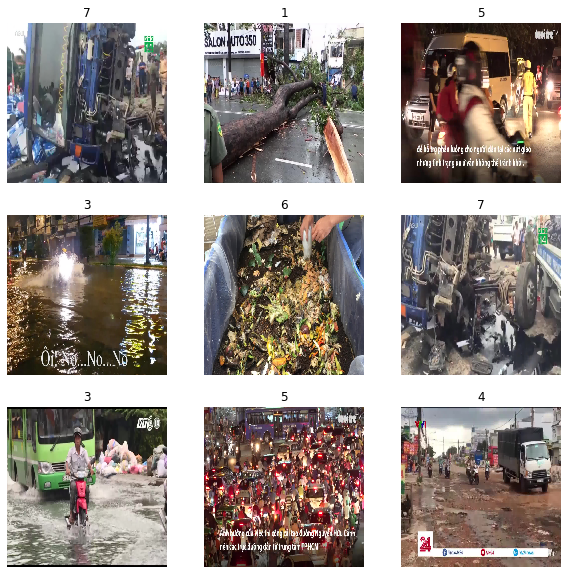

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

160


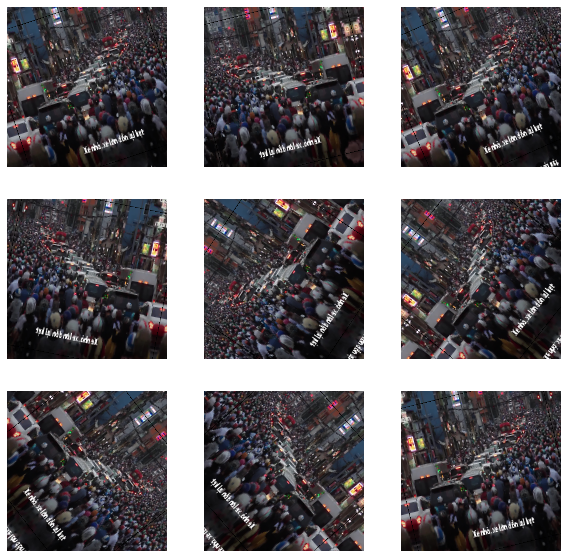

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  print(len(first_image))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
base_model = InceptionV3(input_shape=IMG_SHAPE,
                        include_top=False,
                        weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 79, 79, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 79, 79, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 79, 79, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 3, 3, 2048)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 8)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
opt = tf.keras.optimizers.Adam(lr=base_learning_rate)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

4

In [ ]:
initial_epochs = 10

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
323/323 [==============================] - 40s 123ms/step - loss: 1.8584 - accuracy: 0.4125 - val_loss: 1.7793 - val_accuracy: 0.4913
Epoch 2/10
323/323 [==============================] - 39s 122ms/step - loss: 1.7193 - accuracy: 0.5509 - val_loss: 1.6961 - val_accuracy: 0.5844
Epoch 3/10
323/323 [==============================] - 38s 119ms/step - loss: 1.6574 - accuracy: 0.6135 - val_loss: 1.6084 - val_accuracy: 0.6650
Epoch 4/10
323/323 [==============================] - 38s 119ms/step - loss: 1.5639 - accuracy: 0.7072 - val_loss: 1.4745 - val_accuracy: 0.7978
Epoch 5/10
323/323 [==============================] - 38s 118ms/step - loss: 1.4933 - accuracy: 0.7816 - val_loss: 1.4949 - val_accuracy: 0.7866
Epoch 6/10
323/323 [==============================] - 38s 119ms/step - loss: 1.4719 - accuracy: 0.8030 - val_loss: 1.4590 - val_accuracy: 0.8151
Epoch 7/10
323/323 [==============================] - 38s 119ms/step - loss: 1.4669 - accuracy: 0.8133 - val_loss: 1.4825 - val_ac

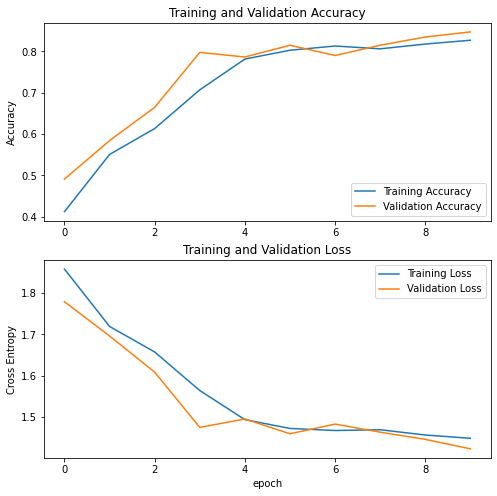

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 249

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_5 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_5 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2048)             

In [ ]:
len(model.trainable_variables)

40

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
323/323 [==============================] - 44s 135ms/step - loss: 1.4132 - accuracy: 0.8645 - val_loss: 1.4325 - val_accuracy: 0.8412
Epoch 11/20
323/323 [==============================] - 43s 132ms/step - loss: 1.3989 - accuracy: 0.8759 - val_loss: 1.4019 - val_accuracy: 0.8747
Epoch 12/20
323/323 [==============================] - 40s 125ms/step - loss: 1.3893 - accuracy: 0.8855 - val_loss: 1.3947 - val_accuracy: 0.8834
Epoch 13/20
323/323 [==============================] - 40s 125ms/step - loss: 1.3691 - accuracy: 0.9066 - val_loss: 1.3922 - val_accuracy: 0.8821
Epoch 14/20
323/323 [==============================] - 42s 129ms/step - loss: 1.3673 - accuracy: 0.9091 - val_loss: 1.4048 - val_accuracy: 0.8697
Epoch 15/20
323/323 [==============================] - 44s 136ms/step - loss: 1.3576 - accuracy: 0.9172 - val_loss: 1.3771 - val_accuracy: 0.8970
Epoch 16/20
323/323 [==============================] - 43s 132ms/step - loss: 1.3593 - accuracy: 0.9159 - val_loss: 1.3851 -

In [ ]:
model.save('/content/drive/MyDrive/inceptionv3.h5')

In [16]:
model = load_model('/content/drive/MyDrive/inceptionv3.h5')

In [ ]:
from dataloader import path_to_image
paths = os.listdir('/content/drive/MyDrive/result/')
test_dataset = []
final_predictions = []
final_path = []
true_class = []
count = 0
for folder in paths:
  path = '/content/drive/MyDrive/result/' + folder + '/'
  for i in os.listdir(path):
    img= path_to_image(path+i,(160,160),3,'bilinear')
    true_class.append(folder)
    new_img = np.expand_dims(img,0)
    prediction = model.predict(new_img)
    pre = np.argmax(prediction, axis=-1)
    final_predictions.append(pre)
    final_path.append(path+i)
    if count%100 == 0:
      print(count)
    count+=1

0
100


In [ ]:
print (len(final_predictions))

385


In [ ]:
predict = []
for pred in final_predictions:
  predict.append(class_names[pred[0]])

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_mat_rfc = confusion_matrix(true_class, predict, labels = class_names)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix',export_as='confusion_matrix', cmap='Oranges'):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16, color="white")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,  classes, rotation=0, fontsize=12, color="white")
    plt.yticks(tick_marks,  classes, fontsize=12, color="white")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=18, color = 'white')
    plt.xlabel('Predicted labels', fontsize=18, color="white")

Normalized confusion matrix


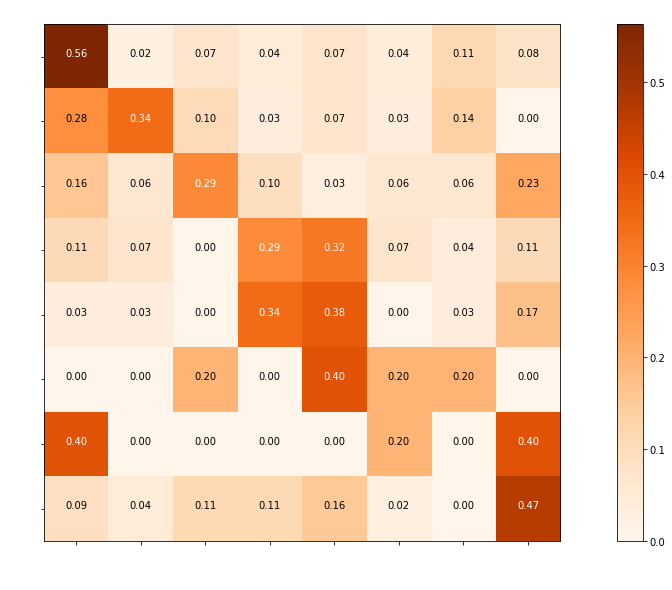

In [ ]:
cm_plot_labels = class_names

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat_rfc, cm_plot_labels, normalize=True,
                      title="Confusion Matrix "
                     )

plt.show()